# RELAX CHALLENGE

In [43]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

## 1. Data Wrangling

In [3]:
df_users = pd.read_csv('takehome_users.csv', encoding='latin-1', parse_dates=True)
df_eng = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)

In [4]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Columns like name and email will probably not be useful for our analysis so we will drop them.

In [5]:
df_users.drop(['name', 'email'], axis=1, inplace=True)

In [6]:
df_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
print(f'There were {df_eng.user_id.nunique()} users and {len(df_eng)} logins in total')

There were 8823 users and 207917 logins in total


In [8]:
df_eng['time_stamp'] = pd.to_datetime(df_eng['time_stamp'], format='%Y-%m-%d %H:%M:%S')
df_eng.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [9]:
def adopted_user(df, days=7, logins=3):
    df['date'] = df_eng['time_stamp'].dt.date
    df.drop_duplicates('date').sort_values(by='date')
    #how many days passed for every 3 logins
    days_passed = df['date'].diff(periods=logins-1)
    #check if there are any days_passed more than 7 days
    return any(days_passed <= timedelta(days=days))

In [10]:
adopted_users = df_eng.groupby('user_id').apply(adopted_user)

In [11]:
df_adopted_users = pd.DataFrame(adopted_users, columns=['adopted']).reset_index()

In [12]:
df_adopted_users

,user_id,adopted
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False
...,...,...
8818,11996,False
8819,11997,False
8820,11998,False
8821,11999,False


In [13]:
tot = len(df_adopted_users)

In [14]:
adpt = df_adopted_users['adopted'].sum()

In [15]:
pct = (adpt / tot) * 100

In [16]:
print(f'There were {adpt} adopted users out of {tot} users, which is {round(pct, 2)}%')

There were 1656 adopted users out of 8823 users, which is 18.77%


It would be logical to assume that people who have been using the product for a long time are more likely to become adopted users. However, we don't have a feature showing us how long the user has been using the product. We can engineer is though, since we already have 'creation_time' and 'last_session_creation_time' features, by substracting the former from the latter.

In [17]:
df_users['creation_time'] = pd.to_datetime(
    df_users['creation_time'], format='%Y-%m-%d %H:%M:%S')
df_users['last_session_creation_time'] = pd.to_datetime(
    df_users['last_session_creation_time'], unit='s')
#history - number of days between account creation time and last session time
df_users['history'] = (df_users['last_session_creation_time'] - df_users['creation_time']).dt.days
#account age - number of days since account creation
latest = max(df_users['creation_time'])
df_users['account_age'] = latest - df_users['creation_time']
df_users['account_age'] = df_users['account_age'].dt.days
#since the original features wold be redundant for the analysis we will drop them
df_users.drop(['creation_time', 'last_session_creation_time'], axis=1, inplace=True)

In [18]:
df_users

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,account_age
0,1,GUEST_INVITE,1,0,11,10803.0,0.0,38
1,2,ORG_INVITE,0,0,1,316.0,136.0,196
2,3,ORG_INVITE,0,0,94,1525.0,0.0,437
3,4,GUEST_INVITE,0,0,1,5151.0,1.0,374
4,5,GUEST_INVITE,0,0,193,5240.0,5.0,498
...,...,...,...,...,...,...,...,...
11995,11996,ORG_INVITE,0,0,89,8263.0,0.0,266
11996,11997,SIGNUP_GOOGLE_AUTH,0,0,200,NaN,5.0,505
11997,11998,GUEST_INVITE,1,1,83,8074.0,0.0,33
11998,11999,PERSONAL_PROJECTS,0,0,6,NaN,2.0,729


Now let's take a look at the users with the most invites sent and organizations with the biggest amount of users.

In [19]:
df_users['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [20]:
#total number of organizations
df_users['org_id'].nunique()

417

In [21]:
df_users['invited_by_user_id'].value_counts().head()

10741.0    13
2527.0     12
11770.0    11
1525.0     11
2308.0     11
Name: invited_by_user_id, dtype: int64

In [22]:
#total number of users who sent invitations
df_users['invited_by_user_id'].nunique()

2564

There are 417 organizations and 2564 users who sent invitations.

In [23]:
df_users.drop(['org_id', 'invited_by_user_id'], axis=1, inplace=True)

In [24]:
df_users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
0,1,GUEST_INVITE,1,0,0.0,38
1,2,ORG_INVITE,0,0,136.0,196
2,3,ORG_INVITE,0,0,0.0,437
3,4,GUEST_INVITE,0,0,1.0,374
4,5,GUEST_INVITE,0,0,5.0,498


In [25]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   history                     8823 non-null   float64
 5   account_age                 12000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 562.6+ KB


We can see that out of 12000 users 8823 have history. Now let's merge our "adopted users" with "df_users" dataframe.

In [26]:
df_users = df_users.set_index('object_id')
df_users.index.name = 'user_id'

In [27]:
df_users

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
user_id,,,,,
1,GUEST_INVITE,1,0,0.0,38
2,ORG_INVITE,0,0,136.0,196
3,ORG_INVITE,0,0,0.0,437
4,GUEST_INVITE,0,0,1.0,374
5,GUEST_INVITE,0,0,5.0,498
...,...,...,...,...,...
11996,ORG_INVITE,0,0,0.0,266
11997,SIGNUP_GOOGLE_AUTH,0,0,5.0,505
11998,GUEST_INVITE,1,1,0.0,33


In [28]:
df_adopted_users.set_index('user_id')

,adopted
user_id,
1,False
2,True
3,False
4,False
5,False
...,...
11996,False
11997,False
11998,False


In [29]:
df = pd.concat([df_users, df_adopted_users], axis=1, join='inner')

In [30]:
#converting boolean values to numerical
df['adopted'] = df['adopted'].astype('int')

In [31]:
df.head(10)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age,user_id,adopted
1,GUEST_INVITE,1,0,0.0,38,2,1
2,ORG_INVITE,0,0,136.0,196,3,0
3,ORG_INVITE,0,0,0.0,437,4,0
4,GUEST_INVITE,0,0,1.0,374,5,0
5,GUEST_INVITE,0,0,5.0,498,6,0
6,GUEST_INVITE,0,0,2.0,164,7,0
7,SIGNUP,0,1,4.0,530,10,1
8,PERSONAL_PROJECTS,1,1,NaN,303,11,0
9,PERSONAL_PROJECTS,0,0,NaN,206,13,0
10,ORG_INVITE,1,1,503.0,499,14,0


In [32]:
df.dropna(axis=1, inplace=True)

In [33]:
df['adopted'].dtype

dtype('int32')

## 2. Exploratory Data Analysis

Now we will try to find out if there are any interesting relationships between the features in our dataframe.
First, let's take a look at countplots.

In [34]:
y = df['adopted']
X = df.drop(['user_id'], axis=1)

In [35]:
def plot_countplots(col, df, hue='adopted'):
    plt.figure(figsize=(12,6))
    sns.countplot(x=col, data=df, hue=hue)
    plt.xticks(rotation=45)
    plt.show;

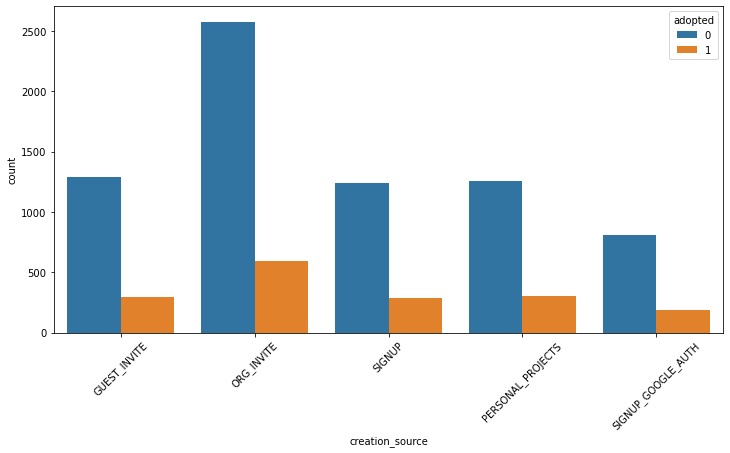

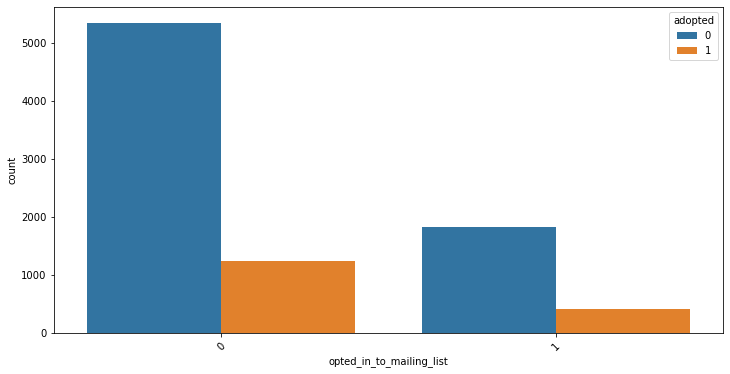

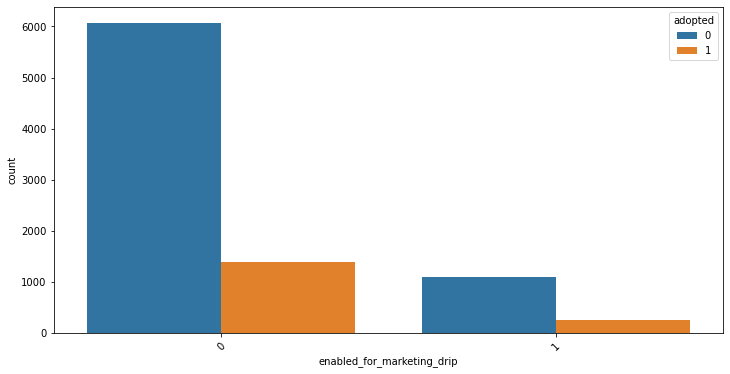

In [36]:
for col in X:
    if col != 'account_age' and col !='adopted':
        plot_countplots(col, X, hue='adopted')

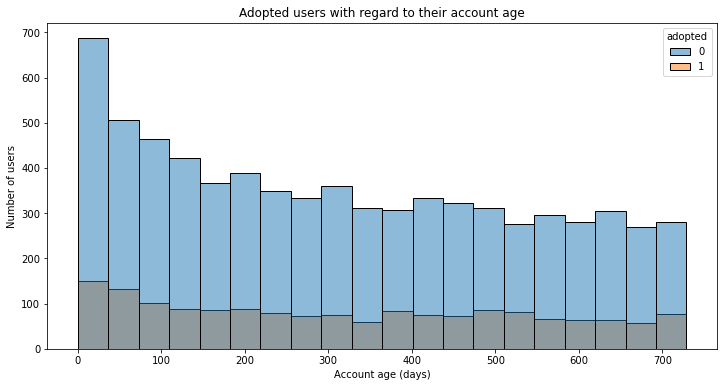

In [37]:
plt.figure(figsize=(12,6))
sns.histplot(x='account_age', data=df, hue='adopted', bins=20, color='blue')
plt.xlabel('Account age (days)')
plt.ylabel('Number of users')
plt.title('Adopted users with regard to their account age')
plt.show();

It is not clear from the visualizations if there are any relationships between the features and the target ("adopted"). We can see, however, that newer accounts have slightly higher rate of adoption.

Let's see what source has the highest rate of adoption.

In [38]:
df.groupby('creation_source')['adopted'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.186237
ORG_INVITE            0.186987
PERSONAL_PROJECTS     0.192159
SIGNUP                0.186719
SIGNUP_GOOGLE_AUTH    0.186935
Name: adopted, dtype: float64

We can see that PERSONAL_PROJECTS has the highest ratio, even though they are all quite close to each other.

No we will perform modeling. We will use random forest classifier and then will see what feature was the most important for predicting user adoption.<br>
<br>
Since we have non-numeric variables in CREATION_SOURCE column we will need to use dummy variables for this column.

In [39]:
creation_source = pd.get_dummies(df['creation_source'], drop_first=True)
data = pd.concat([df, creation_source], axis=1).drop('creation_source', axis=1)

Let's separate our target variable from features...

In [40]:
y = data['adopted']
X = data.drop('adopted', axis=1)

... split the data into train and test sets ...

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

... scale the data using standard scaler.

In [45]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [46]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7057, 8)
(7057,)
(1765, 8)
(1765,)


In [56]:
rfc = RandomForestClassifier(oob_score=True, class_weight='balanced')
rfc.fit(X_train, y_train)
rfc_ypred = rfc.predict(X_test)
print('ACCURACY SCORE: ', accuracy_score(rfc_ypred, y_test))
print('Out-of-bag SCORE: ', rfc.oob_score_)

ACCURACY SCORE:  0.7835694050991502
Out-of-bag SCORE:  0.7735581691937083


In [48]:
print("=== Classification Report ===")
print(classification_report(y_test, rfc_ypred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1434
           1       0.22      0.07      0.11       331

    accuracy                           0.78      1765
   macro avg       0.52      0.51      0.49      1765
weighted avg       0.70      0.78      0.73      1765



As we can see, our out-of-box model did way better job predicting users who were not adopted than those who were. Now let's use GridSearch in order to find the best hyperparameters for our random forest.

In [51]:
#number of trees
n_estimators = [int(i) for i in np.linspace(200, 2000, 10)]

#number of features for each split
max_features = ['auto', 'sqrt']

#maximal depth
max_depth = [int(i) for i in np.linspace(100, 500, 11)]

#parameters grid
grid_params = {'n_estimators':n_estimators, 'max_features':max_features, 'max_depth':max_depth}

In [53]:
rfc_grid = GridSearchCV(rfc, param_grid = grid_params, cv=5, n_jobs=-1)
rfc_grid.fit(X_train, y_train)
rfc_grid.best_params_

{'max_depth': 260, 'max_features': 'sqrt', 'n_estimators': 800}

Let's fit the model with these parameters.

In [57]:
rfc_params = RandomForestClassifier(n_estimators=800, max_features='sqrt', max_depth=260, oob_score=True, class_weight='balanced')
rfc_params.fit(X_train, y_train)
rfc_ypred_params = rfc_params.predict(X_test)
print('ACCURACY SCORE: ', accuracy_score(rfc_ypred_params, y_test))
print('Out-of-bag SCORE: ', rfc_params.oob_score_)

ACCURACY SCORE:  0.7835694050991502
Out-of-bag SCORE:  0.7766756412073119


In [58]:
print("=== RANDOM FOREST (TUNED) Classification Report ===")
print(classification_report(y_test, rfc_ypred_params))

=== RANDOM FOREST (TUNED) Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.95      0.88      1434
           1       0.23      0.07      0.10       331

    accuracy                           0.78      1765
   macro avg       0.52      0.51      0.49      1765
weighted avg       0.71      0.78      0.73      1765



Tuning didn't really improv the resutls.

In [59]:
imp = pd.Series(rfc_params.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

user_id                       0.504581
account_age                   0.460435
opted_in_to_mailing_list      0.008274
enabled_for_marketing_drip    0.008181
ORG_INVITE                    0.005213
SIGNUP                        0.004519
PERSONAL_PROJECTS             0.004402
SIGNUP_GOOGLE_AUTH            0.004396
dtype: float64


We can disregard "user_id" column since it doesn't really give us any information. Other than that, we can see that "account_age" is by far the most important feature that helps to predict user adoption. It makes sense. In order to improve user adoption I would recommend to develop a strategy that will keep new after they sign up. The longer they will use the service, the higher will be the chance that they will stick to it and become adopted users.